<a href="https://colab.research.google.com/github/aishwaryaanaidu/birdcall-identification/blob/main/bird_call.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import librosa, librosa.display
import os
from matplotlib import pyplot as plt
import IPython.display as ipd
import numpy as np
import torch
# matplotlib inline
from pydub import AudioSegment
# import FigureCanvasAgg as FigureCanvas
from os import path
import subprocess
import csv
from csv import writer

#Keras imports
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import model_from_json
import pandas as pd
from PIL import Image
from keras.utils import np_utils
from sklearn import preprocessing
from matplotlib.image import imread

imheight = 360
imwidth = 540

In [25]:
pip install matplotlib

In [12]:
def create_spectrogram():
    # imheight = 50
    # imwidth = 34
    train_dir = "drive/MyDrive/Colab Notebooks/Spectrograms/train_spectr"
    test_dir = "drive/MyDrive/Colab Notebooks/Spectrograms/test_spectr"
    os.mkdir(train_dir)
    os.mkdir(test_dir)
    train_list = [["path", "label"]]
    test_list = [["path", "label"]]
    for bird in os.listdir(directory):
        dir_len = len(os.listdir(directory + "/" + bird)[:3])
        train_count = round(dir_len * 0.7)
        count = 1
        for filename in os.listdir(directory + "/" + bird)[:3]:
            if count <= train_count:
                new_dir = train_dir
                train_list.append([new_dir + "/" + filename.split(".")[0] + ".png", bird])
            else:
                new_dir = test_dir
                test_list.append([new_dir + "/" + filename.split(".")[0] + ".png", bird])
            src = directory + "/" + bird + "/" + filename
            save_path = new_dir + "/" + filename.split(".")[0] + ".png"
            # print(src)
            # print(save_path)

            dst = "test.wav"
            # params
            sampling = 21952
            hop_length = 245
            n_mels = 224
            n_fft = 892
            win_length = n_fft
            plt.rcParams["figure.figsize"] = [7.50, 5.00]
            plt.rcParams["figure.autolayout"] = True

            # convert mp3 to wav
            sound = AudioSegment.from_mp3(src)
            sound.export(dst, format="wav")
            signal, Fs = librosa.load(dst, sr=21952)

            # Load signal and plot
            signal,Fs = librosa.load(dst,sr=sampling,mono=True,res_type="kaiser_fast")
            plt.axis('off')

            # Create spectrogram and plot
            spectr = librosa.feature.melspectrogram(signal, sr=sampling, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length,
                                                    win_length=win_length, fmin=300)
            log_spectr = librosa.amplitude_to_db(spectr)

            librosa.display.specshow(log_spectr, sr=sampling, hop_length=hop_length)
            plt.savefig(save_path)
            
            gray = Image.open(save_path).convert('L')
            gray.save(save_path)
            

            count += 1
    return train_list, test_list

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
def list_to_csv(train_lis, test_lis):
    file1 = open('train.csv', 'w+', newline = '')
    file2 = open('test.csv', 'w+', newline = '')
    with file1:
        write = csv.writer(file1)
        write.writerows(train_lis)
    with file2:
        write = csv.writer(file2)
        write.writerows(test_lis)

In [23]:
def img_to_numpy_array(path):
    return imread(path)

In [87]:
def create_train_test(trl, tel):
    train = pd.read_csv("train.csv")
    test = pd.read_csv("test.csv")
    y_test = np.zeros(len(tel[1:]), str)
    y_train = np.zeros(len(trl[1:]), str)
    x_train = np.zeros((len(trl[1:]), imheight, imwidth))
    x_test = np.zeros((len(tel[1:]), imheight, imwidth))

    # print("path {}".format(len(train["path"])))
    

    # for path in train["path"]:
    #     x_train = np.append(x_train, img_to_numpy_array(path))
    # for label in train["label"]:
    #     y_train = np.append(y_train, label)
    # for path in test["path"]:
    #     x_test = np.append(x_test, img_to_numpy_array(path))
    # for label in train["label"]:
    #     y_test = np.append(y_test, label)
    # le = preprocessing.LabelEncoder()
    # le.fit(y_train)
    # y_train = le.transform(y_train)
    # y_test = le.transform(y_test)
    

    # y_train = np_utils.to_categorical(y_train, num_classes)
    # y_test = np_utils.to_categorical(y_test, num_classes)

    for i, f in enumerate(tel[1:]):
        y_test[i]     = f[1]
        x_test[i,:,:] = img_to_numpy_array(f[0])

    for i, f in enumerate(trl[1:]):
        y_train[i]     = f[1]
        x_train[i,:,:] = img_to_numpy_array(f[0])
        
    return x_train, y_train, x_test, y_test

In [88]:
def create_model(trl, tel):
    # train = pd.read_csv("train.csv")
    # test = pd.read_csv("test.csv")
    # x_train, y_train, x_test, y_test = train["path"], train["label"], test["path"], test["label"]
    x_train, y_train, x_test, y_test = create_train_test(trl, tel)

    print("Size of Training Data:", np.shape(x_train))
    print("Size of Training Labels:", np.shape(y_train))
    print("Size of Test Data:", np.shape(x_test))
    print("Size of Test Labels:", np.shape(y_test))
    
    le = preprocessing.LabelEncoder()
    le.fit(y_train)
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    

    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)

    print("HIiiiii")
    print(x_train.shape)
    x_train = x_train.reshape(x_train.shape[0], imheight, imwidth, 1)
    x_test = x_test.reshape(x_test.shape[0], imheight, imwidth, 1)
    
    input_shape = (imheight, imwidth, 1)
    batch_size = 2
    epochs = 1

    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.25))    
    model.add(Dense(128, activation='relu'))
#     model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
#     opt = keras.optimizers.Adam(learning_rate=0.01)

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=['accuracy'])
    print(model.summary())

    model.fit(x_train, y_train, batch_size=4, epochs=10, verbose=1, validation_data=(x_test, y_test))
    return model

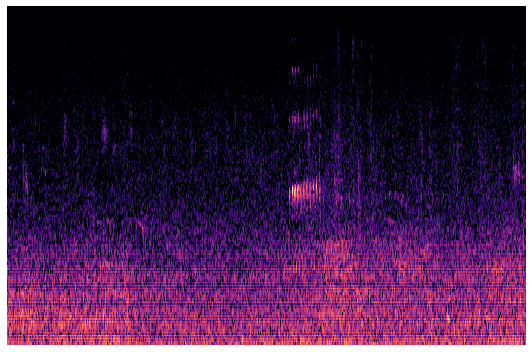

In [13]:
directory = "drive/MyDrive/Colab Notebooks/IndianaBirds"


trl, tel = create_spectrogram()
list_to_csv(trl, tel)

In [89]:
num_classes = 5
m = create_model(trl, tel)
print(m.summary())

Size of Training Data: (8, 360, 540)
Size of Training Labels: (8,)
Size of Test Data: (4, 360, 540)
Size of Test Labels: (4,)
HIiiiii
(8, 360, 540)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 358, 538, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 356, 536, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 178, 268, 64)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3053056)           0         
                                                                 
 dropout_4 (Dropout)         (None, 3053056)           0         
                                      